In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [48]:
# csv to pandas DataFrame
df_emg = pd.read_csv('F_sujeto_1.csv', header=None)
df_angulos = pd.read_csv('datos_F_1.csv')

In [49]:
# primeros 5 valores de cada DataFrame
df_emg.columns = ['EMG']
df_emg.head()

,EMG
0,-610.6
1,-551.3
2,-547.0
3,-687.6
4,-690.6


In [50]:
df_angulos.head()

,Time (ms),Angulo 1
0,0,170.913376
1,33,170.904419
2,67,170.898117
3,100,170.893661
4,133,170.885590


In [51]:
# Duración total de la captura
total_time = df_angulos["Time (ms)"].iloc[-1] / 1000  # convertir ms a s

# Ventana de tiempo correspondiente a cada muestra de ángulo
window_size = int(df_emg.shape[0] / len(df_angulos))  # Aproximadamente 337 muestras EMG por ventana de 33 ms

# Función para extraer características de una ventana de EMG
def extract_features(emg_window):
    features = {
        'RMS': np.sqrt(np.mean(emg_window ** 2)),
        'Mean': np.mean(emg_window),
        'Std': np.std(emg_window),
        'Max': np.max(emg_window),
        'Min': np.min(emg_window)
    }
    return np.array(list(features.values()))

# Extraer características de cada ventana
emg_features = []
for i in range(0, df_emg.shape[0] - window_size + 1, window_size):
    emg_window = df_emg['EMG'].iloc[i:i + window_size].values
    features = extract_features(emg_window)
    emg_features.append(features)

In [52]:
# Convertir características EMG a DataFrame
df_emg_features = pd.DataFrame(emg_features, columns=['RMS', 'Mean', 'Std', 'Max', 'Min'])

# Alinear las características EMG con los valores angulares
aligned_angulos = df_angulos['Angulo 1'][:len(df_emg_features)].values

# Escalar características y valores angulares
scaler_features = StandardScaler()
scaler_angles = StandardScaler()
X_scaled = scaler_features.fit_transform(df_emg_features)
y_scaled = scaler_angles.fit_transform(aligned_angulos.reshape(-1, 1))

In [53]:
df_emg_features.head()

,RMS,Mean,Std,Max,Min
0,582.774123,-565.691395,140.067570,-9.9,-706.2
1,577.301795,-557.175668,151.104723,1.8,-704.0
2,577.743414,-558.205935,148.975123,3.9,-703.3
3,584.991820,-564.635608,152.977317,-0.1,-706.6
4,575.614249,-553.849852,156.786817,40.4,-699.3


In [56]:
# División en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convertir a tensores para PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Crear DataLoaders
batch_size = 30
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

In [63]:
X_train_tensor.shape, y_train_tensor.shape

(torch.Size([2425, 5]), torch.Size([2425, 1]))

In [57]:
torch.cuda.is_available()

True

In [58]:
# Estructura de la red LSTM en PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Capa densa de salida

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)  # Estado oculto inicial
        c_0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)  # Estado de celda inicial

        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])  # Predicción usando la última salida de la LSTM
        return out

# Parámetros del modelo
input_size = X_train_tensor.shape[1]  # Número de características
hidden_size = 20  # Hidden layer de 20 cells
output_size = 1  # Predicción del valor angular
num_layers = 1  # Número de capas LSTM

# Instanciar el modelo y moverlo al dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)

# Configuración del optimizador y función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-7)
criterion = nn.MSELoss()

# Variables para almacenar las pérdidas
train_losses = []
val_losses = []

In [59]:
# Bucle de entrenamiento con soporte para GPU
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Mover batch al dispositivo
        optimizer.zero_grad()
        y_pred = model(X_batch.unsqueeze(1))
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch.unsqueeze(1))
            val_loss += criterion(y_val_pred, y_val_batch).item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")

Epoch 1/50, Train Loss: 0.9906231083987672, Val Loss: 0.9910096195009019
Epoch 2/50, Train Loss: 0.9576342083789684, Val Loss: 0.973125523991055
Epoch 3/50, Train Loss: 0.932901120480196, Val Loss: 0.9603029059039222
Epoch 4/50, Train Loss: 0.9114115451589043, Val Loss: 0.9459656493531333
Epoch 5/50, Train Loss: 0.8916226338457178, Val Loss: 0.9299490335914824
Epoch 6/50, Train Loss: 0.8748054695718083, Val Loss: 0.907350136174096
Epoch 7/50, Train Loss: 0.8584532818676512, Val Loss: 0.8809579329358207
Epoch 8/50, Train Loss: 0.8406946261723837, Val Loss: 0.8550456646415923
Epoch 9/50, Train Loss: 0.8224210017993127, Val Loss: 0.825976625084877
Epoch 10/50, Train Loss: 0.8050521148575677, Val Loss: 0.8001280840900209
Epoch 11/50, Train Loss: 0.7899237687205091, Val Loss: 0.7825256437063217
Epoch 12/50, Train Loss: 0.7767517765363058, Val Loss: 0.7559021098746194
Epoch 13/50, Train Loss: 0.7668023565669119, Val Loss: 0.7383829711212052
Epoch 14/50, Train Loss: 0.7525288543583434, Val Lo

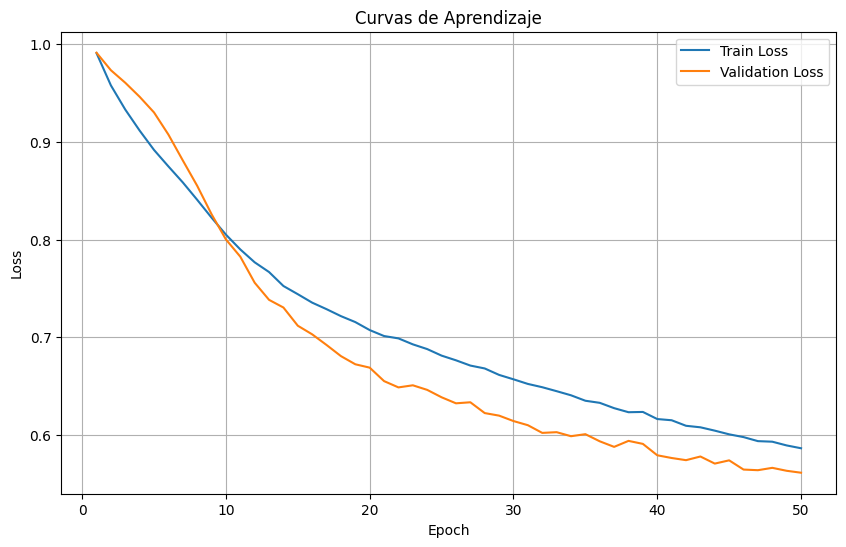

In [64]:
# prompt: grafica de las curvas de aprendizaje

# Gráfica de las curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Curvas de Aprendizaje')
plt.legend()
plt.grid(True)
plt.show()